In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score, classification_report, confusion_matrix

In [2]:
df=pd.read_csv(r"C:\Users\reyha\Desktop\data science class\preprocess\heart.csv")

In [3]:
df.shape

(918, 12)

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

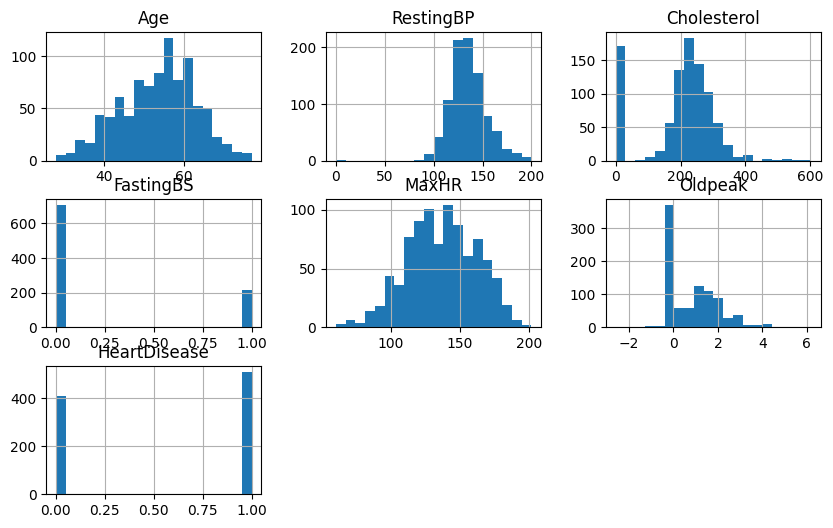

In [5]:
df.hist(bins=20,figsize=(10,6))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [8]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [9]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [10]:
data=df.copy()

In [11]:

target = data.columns[-1]
y = data[target].values


categorical_cols = ["Sex", "ExerciseAngina", "ChestPainType", "RestingECG", "ST_Slope"]
for col in categorical_cols:
    if col in data.columns:
        print(f"--- {col} ---")
        print(data[col].value_counts().sort_index())
        print("Unique categories:", data[col].unique())
        print("Number of categories:", data[col].nunique())
        print()



--- Sex ---
Sex
F    193
M    725
Name: count, dtype: int64
Unique categories: ['M' 'F']
Number of categories: 2

--- ExerciseAngina ---
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64
Unique categories: ['N' 'Y']
Number of categories: 2

--- ChestPainType ---
ChestPainType
ASY    496
ATA    173
NAP    203
TA      46
Name: count, dtype: int64
Unique categories: ['ATA' 'NAP' 'ASY' 'TA']
Number of categories: 4

--- RestingECG ---
RestingECG
LVH       188
Normal    552
ST        178
Name: count, dtype: int64
Unique categories: ['Normal' 'ST' 'LVH']
Number of categories: 3

--- ST_Slope ---
ST_Slope
Down     63
Flat    460
Up      395
Name: count, dtype: int64
Unique categories: ['Up' 'Flat' 'Down']
Number of categories: 3



In [12]:
binary_cols = ["Sex", "ExerciseAngina"]                      
categorical_oh_cols = ["ChestPainType", "RestingECG", "ST_Slope"]

numeric_cols = [c for c in data.columns if c not in categorical_cols + [target]]


zero_as_missing = ["Age","RestingBP","Cholesterol","MaxHR"]
for col in zero_as_missing:
    if col in data.columns:
        data[col] = data[col].replace(0, np.nan) 

In [13]:


numeric_transform = Pipeline(steps=[
    ("imputer_num", KNNImputer(n_neighbors=3)),  
    ("scaler", StandardScaler())
])

binary_transform = Pipeline(steps=[
    ("imputer_bin", SimpleImputer(strategy="most_frequent")),
   
    ("onehot_bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore", dtype=int))
])

categorical_transform = Pipeline(steps=[
    ("imputer_cat", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transform, numeric_cols),
        ("cat", categorical_transform, categorical_cols)
    ],
    remainder="drop"
)


In [14]:


svm_clf = SVC(probability=True, class_weight="balanced", random_state=42)  
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("svm", svm_clf)
])

C = np.arange(0.5, 2.1, 0.3)

gamma = np.logspace(-3, -1, 5)
params = {
    "svm__kernel": ["linear", "rbf"],
    "svm__C": C,
    "svm__gamma": ["scale", "auto"] + list(gamma) 
}

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=567)

clf = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring=scoring,
    refit="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)


In [15]:
 
X = data.drop(columns=[target])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123, stratify=y
)

In [16]:


clf.fit(X_train, y_train)

print("Best params:", clf.best_params_)
print("Best CV AUC (mean):", clf.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best params: {'svm__C': 1.1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best CV AUC (mean): 0.9216256653113021


In [17]:
print(clf.best_params_) 
print(clf.best_score_)    
best_model = clf.best_estimator_  
results = pd.DataFrame(clf.cv_results_)
print(results[[
    "mean_test_accuracy", "mean_test_precision", "mean_test_recall",
    "mean_test_f1", "mean_test_roc_auc", "mean_test_pr_auc"
]])

{'svm__C': 1.1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
0.9216256653113021
    mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1  \
0             0.852866             0.858149          0.881692      0.869108   
1             0.862380             0.861998          0.896447      0.878006   
2             0.852866             0.858149          0.881692      0.869108   
3             0.865110             0.869211          0.891509      0.879485   
4             0.852866             0.858149          0.881692      0.869108   
..                 ...                  ...               ...           ...   
79            0.861029             0.868112          0.884101      0.875433   
80            0.852856             0.859703          0.879223      0.868745   
81            0.862389             0.867410          0.889039      0.877215   
82            0.852856             0.859703          0.879223      0.868745   
83            0.860992             0.863598          0

In [18]:


best_pipe = clf.best_estimator_
y_proba_test = best_pipe.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("Test ROC-AUC (pre-calib):", roc_auc_score(y_test, y_proba_test))
print("Test PR-AUC (pre-calib):", average_precision_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test, normalize='true')
print("Normalized Confusion Matrix:\n", cm)


Test ROC-AUC (pre-calib): 0.9256336681013869
Test PR-AUC (pre-calib): 0.9311162150754605
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        82
           1       0.89      0.87      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

Normalized Confusion Matrix:
 [[0.86585366 0.13414634]
 [0.12745098 0.87254902]]


Available columns:
 ['mean_fit_time', 'mean_score_time', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel', 'mean_test_accuracy', 'mean_train_accuracy', 'mean_test_precision', 'mean_train_precision', 'mean_test_recall', 'mean_train_recall', 'mean_test_f1', 'mean_train_f1', 'mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_pr_auc', 'mean_train_pr_auc']


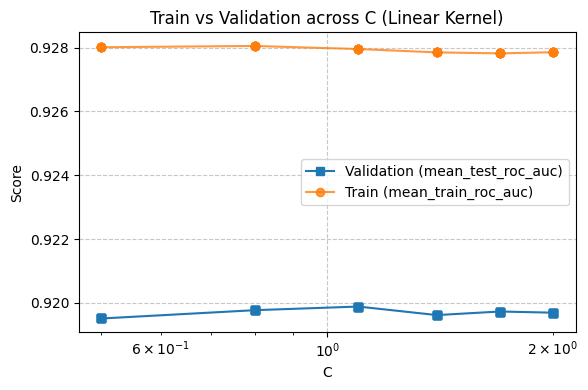

In [19]:
#c charting effect of in linear kernel

results = pd.DataFrame(clf.cv_results_)
print("Available columns:\n", [c for c in results.columns if "mean_" in c or "param_" in c])


def pick_col(df, prefer_list):
    for name in prefer_list:
        if name in df.columns:
            return name
    return None


test_col  = pick_col(results, ["mean_test_score", "mean_test_roc_auc", "mean_test_f1", "mean_test_accuracy"])
train_col = pick_col(results, ["mean_train_score", "mean_train_roc_auc", "mean_train_f1", "mean_train_accuracy"])


linear_results = results[results["param_svm__kernel"] == "linear"].copy()


if linear_results.empty or test_col is None:
    raise ValueError("No linear-kernel rows or suitable test metric columns found in cv_results_. Check your scoring and param grid.")

Cs = linear_results["param_svm__C"].astype(float).values
mean_val = linear_results[test_col].values

plt.figure(figsize=(6,4))
plt.plot(Cs, mean_val, marker="s", label=f"Validation ({test_col})")

if train_col is not None:
    mean_train = linear_results[train_col].values
    plt.plot(Cs, mean_train, marker="o", label=f"Train ({train_col})", alpha=0.8)

plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Score")
plt.title("Train vs Validation across C (Linear Kernel)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


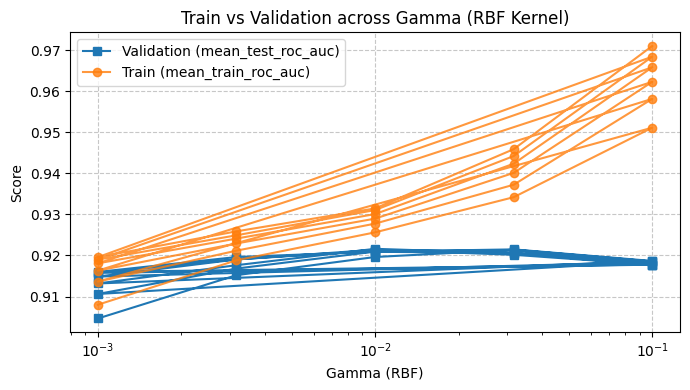

In [20]:
#gamma 

rbf_results = results[results["param_svm__kernel"] == "rbf"].copy()
if not rbf_results.empty:
    
    mask_num_gamma = rbf_results["param_svm__gamma"].apply(lambda v: isinstance(v, (int, float, np.floating)))
    rbf_num = rbf_results[mask_num_gamma]
    if not rbf_num.empty:
        gammas = rbf_num["param_svm__gamma"].astype(float).values
        mean_val_rbf = rbf_num[test_col].values

        plt.figure(figsize=(7,4))
        plt.plot(gammas, mean_val_rbf, marker="s", label=f"Validation ({test_col})")
        if train_col is not None:
            mean_train_rbf = rbf_num[train_col].values
            plt.plot(gammas, mean_train_rbf, marker="o", label=f"Train ({train_col})", alpha=0.8)
        plt.xscale("log")
        plt.xlabel("Gamma (RBF)")
        plt.ylabel("Score")
        plt.title("Train vs Validation across Gamma (RBF Kernel)")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()


In [21]:
calibrator = CalibratedClassifierCV(
    estimator=best_pipe,  
    method="sigmoid",
    cv=5
)
calibrator.fit(X_train, y_train)

y_proba_test_cal = calibrator.predict_proba(X_test)[:, 1]
y_pred_test_cal  = (y_proba_test_cal >= 0.5).astype(int)

print("Test ROC-AUC (calibrated):", roc_auc_score(y_test, y_proba_test_cal))
print("Test PR-AUC (calibrated):", average_precision_score(y_test, y_proba_test_cal))


Test ROC-AUC (calibrated): 0.9253945480631276
Test PR-AUC (calibrated): 0.9309966886614671


In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import numpy as np

proba = y_proba_test  
y     = y_test


frac_pos, mean_pred = calibration_curve(y, proba, n_bins=10, strategy="uniform")


brier = brier_score_loss(y, proba)


bins = np.linspace(0,1,11)
idx  = np.digitize(proba, bins)-1
ece = 0.0
for b in range(10):
    mask = idx==b
    if mask.any():
        avg_p = proba[mask].mean()
        freq  = y[mask].mean()
        ece  += proba[mask].size/len(proba) * abs(avg_p - freq)
print("Brier:", brier, " | ECE:", ece)


Brier: 0.10195281955448364  | ECE: 0.04679212320949222


In [23]:

best_pipe.fit(X_train, y_train)

cal_prefit = CalibratedClassifierCV(
    estimator=best_pipe, method="sigmoid", cv="prefit"
)
cal_prefit.fit(X_train, y_train)


C:\Users\reyha\AppData\Roaming\Python\Python39\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer_num',
                                                                                                    KNNImputer(n_neighbors=3)),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['Age',
                                                                                    'RestingBP',
                                                                                    'Cholesterol',
                                                                                    'FastingBS',
                                                                                    'MaxHR',
                                                                                    'Oldpeak']),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('imputer_cat',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                                   ['Sex',
                                                                                    'ExerciseAngina',
                                                                                    'ChestPainType',
                                                                                    'RestingECG',
                                                                                    'ST_Slope'])])),
                                                 ('svm',
                                                  SVC(C=1.1,
                                                      class_weight='balanced',
                                                      gamma=0.01,
                                                      probability=True,
                                                      random_state=42))]))

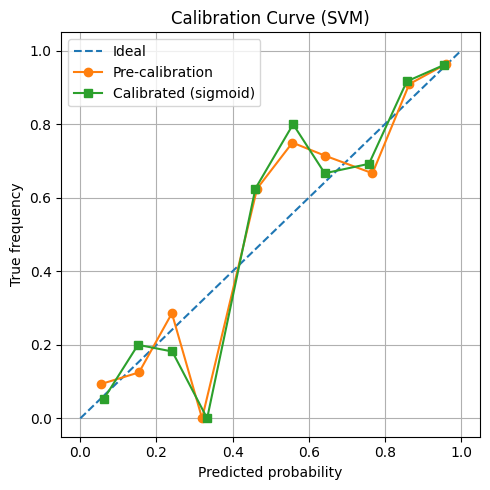

In [24]:

#calibration curve
prob_true_pre, prob_pred_pre = calibration_curve(y_test, y_proba_test, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_test_cal, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], linestyle="--", label="Ideal")
plt.plot(prob_pred_pre, prob_true_pre, marker='o', label="Pre-calibration")
plt.plot(prob_pred_cal, prob_true_cal, marker='s', label="Calibrated (sigmoid)")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.title("Calibration Curve (SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:


from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_proba_test_cal)
target_recall = 0.90

idx = np.argmin(np.abs(rec - target_recall))
best_thr = thr[max(idx-1, 0)] if idx < len(thr) else 0.5

y_pred_thr = (y_proba_test_cal >= best_thr).astype(int)
print(f"Chosen threshold ~ {best_thr:.3f} | Precision={metrics.precision_score(y_test,y_pred_thr):.3f} | Recall={metrics.recall_score(y_test,y_pred_thr):.3f} | F1={metrics.f1_score(y_test,y_pred_thr):.3f}")

Chosen threshold ~ 0.438 | Precision=0.877 | Recall=0.912 | F1=0.894
